# Deep Learning Summary Notebook

We ran a number of deep learning models. During their execution, I saved the results into a CSV file. We are now going to look at all the models and look at which ones performed the best.

<font color="red">which data set and sample size did we use?</font>

Criteria for evaluation:

* I am mainly going to concentrate on the following Star Ratings (in order): 2 and 4. These are generally our problematic classes. 2 has the least amount of examples and 4 tends to be mis-classified as 5's. After that, we will look at Star rating 3's
* We will look at the following metrics for these classes:
  * AUC - this tells us how well the model is able to separate out the various classes
  * From classification report:
    * precision - this tells us when the model predicts a class, how likely is it to be accurate
    * recall - this tell us that out of all the labels, how likely is it to identify all reviews in that label class - although I value this less that precision. As we saw in previous notebooks - there is generally a tradeoff between recall and precision. As we see recall increase generally precision decreases in our models. I would rather have a model where we trust the predictions vs sheer volume of being able to identify the problem classes
    * F1 score - this number takes into account both precision and recall
    
    
Hopefully, by looking at these numbers we will have a model the converges to be the best out of the models that we ran
    



In [1]:
# import sibling utilities
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import importlib

import util.dict_util as du
import util.report_util as ru
import util.plot_util as pu

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vinceluk/anaconda3/envs/

In [2]:
# load report file form all of our deep learning models
importlib.reload(ru)
REPORT_DIR = "../reports"
REPORT_FILE = "2019-11-dl_prototype-report.csv"
ML_REPORT_FILE = f'{REPORT_DIR}/2019-11-01-run_classifiers-50k-report.csv'
report = ru.load_dnn_report(REPORT_DIR, REPORT_FILE, convert_format = True)

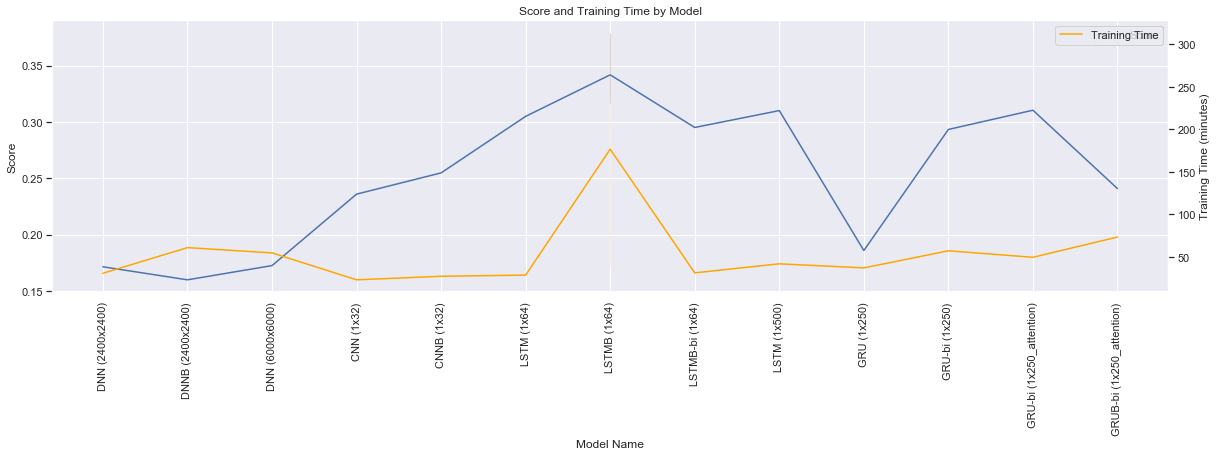

In [3]:
f, a = plt.subplots(1, 1, figsize=(20, 5))
a = sns.lineplot(data = report, x = "display_name", y = "eval_metric", sort = False, label="Score")
_ = plt.xlabel("Model Name")
_ = plt.ylabel("Score")
_ = plt.xticks(rotation=90)

a2 = a.twinx()
_ = sns.lineplot(data = report, x = "display_name", y = "train_time_min", sort = False, ax=a2, label="Training Time", color="orange")
_ = plt.ylabel("Training Time (minutes)")
a2.grid(False)

_ = plt.title("Score and Training Time by Model")



# Compare with our Traditional ML model

LSTM generally has higher precision but is worse at identifying minority classes and have lower recall than logistic regression

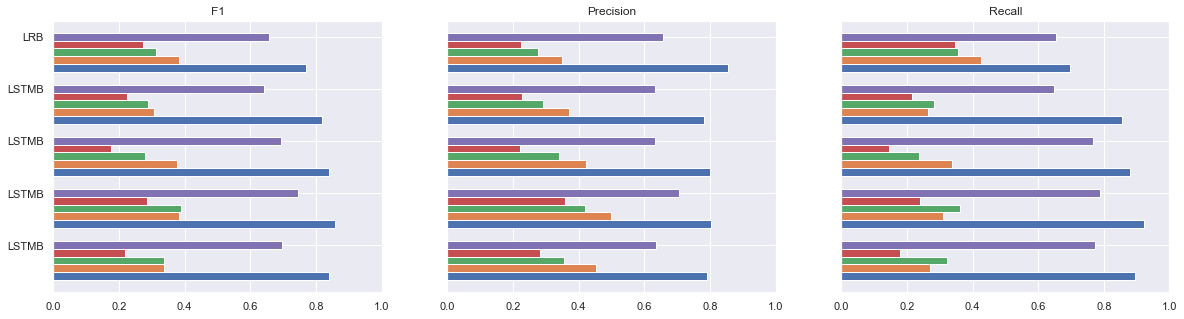

In [4]:
report_ml = ru.load_best_from_report(ML_REPORT_FILE)
report_best = report_ml.append(report[(report.model_name == "LSTMB")], sort=False)
pu.plot_score_histograms(report_best, version=2, label="model_name", sort=False)

### Scores DL models with ML models

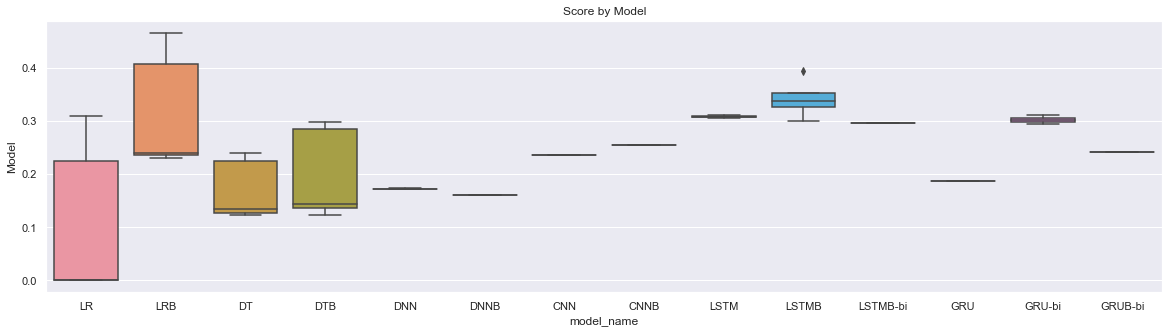

In [5]:
report_all = ru.load_report(ML_REPORT_FILE).append(ru.load_dnn_report(REPORT_DIR, REPORT_FILE, convert_format = True), 
                                                   ignore_index = True,
                                                  sort = False)
f, a = plt.subplots(1, 1, figsize=(20, 5))
sns.boxplot(data = report_all, x="model_name", y="eval_metric")
_ = plt.ylabel("Score")
_ = plt.ylabel("Model")
_ = plt.title("Score by Model")

# LSTM Model Comparison (Balanced Weights)

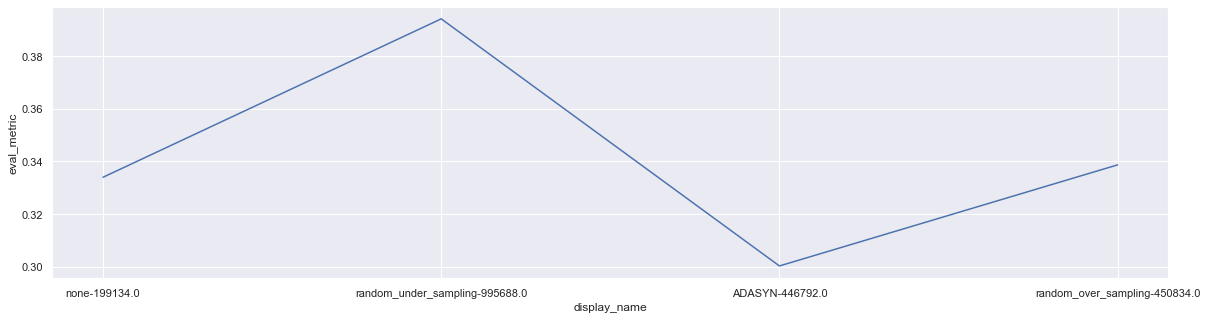

In [7]:
lstms = report[report.model_name == "LSTMB"].copy().astype({"sample_size":np.object})
lstms["display_name"] = lstms[["sample_size", "sampling_type"]].fillna("none").apply(lambda x: x.sampling_type + "-" + str(x.sample_size), axis=1)

plt.figure(figsize=(20, 5))
sns.lineplot(data = lstms, y = "eval_metric", x = "display_name", sort=False)

# Confusion Matrix

* LSTM is having a tough time classifying 2 star reviews
    * It is 2x more likely it will mis-classify it as 1 star, and about 50/50 classifying it to be 3 stars
* LSTM is also having a tough time classifying 4 star reviews
    * In most cases, it is classifying them to be 5 stars and sometimes 3 stars

In [8]:
for idx, row in report_best.iterrows():
    print(f'\n{row.model_name} Sample Size: {row.sample_size} Sampling: {row.sampling_type}')
    print("Confusion Matrix")
    cm = json.loads(row.confusion_matrix)
    print(pd.DataFrame(cm, index=np.arange(1, 6), columns=np.arange(1, 6)))



LRB Sample Size: 49784 Sampling: sampling_none
Confusion Matrix
      1    2    3     4     5
1  1134  374  139    38    50
2   247  280  187    66    26
3   115  278  414   264    96
4    69  140  392   897   605
5   157  171  362  1311  4634

LSTMB Sample Size: 199134.0 Sampling: none
Confusion Matrix
      1    2     3     4      5
1  5387  610   471   111    402
2  1512  576   671   171    295
3   829  522  1466   728    995
4   333  179   963  2232   4591
5   407  147   567  1672  23947

LSTMB Sample Size: 995688.0 Sampling: random_under_sampling
Confusion Matrix
       1     2     3     4      5
1  11195  1402   803   192    604
2   2668  1577  1440   370    544
3   1221  1015  3272  1759   1752
4    325   284  1600  5119   9210
5    475   138   674  2828  49102

LSTMB Sample Size: 446792.0 Sampling: ADASYN
Confusion Matrix
      1    2     3     4      5
1  5355  570   447   232    377
2  1464  467   581   421    292
3   835  449  1071  1300    885
4   293  242   606  2810   43

# Conclusion



In [9]:
report_best.columns

Index(['1_f1-score', '1_precision', '1_recall', '1_support', '2_f1-score',
       '2_precision', '2_recall', '2_support', '3_f1-score', '3_precision',
       '3_recall', '3_support', '4_f1-score', '4_precision', '4_recall',
       '4_support', '5_f1-score', '5_precision', '5_recall', '5_support',
       'accuracy', 'confusion_matrix', 'description', 'file',
       'file_load_time_min', 'macro avg_f1-score', 'macro avg_precision',
       'macro avg_recall', 'macro avg_support', 'model_file', 'model_name',
       'model_save_time_min', 'param', 'predict_time_min', 'smote_time_min',
       'status', 'status_date', 'test_examples', 'test_features',
       'total_time_min', 'train_examples', 'train_features', 'train_time_min',
       'weighted avg_f1-score', 'weighted avg_precision',
       'weighted avg_recall', 'weighted avg_support', 'config_file',
       'eval_metric', 'feature_column', 'feature_engineering', 'config_df',
       'config_ngram', 'sample_size', 'feature_size', 'has_lda', 

In [10]:
from IPython.core.display import display, HTML
display(HTML('<table border="1" cellpadding="3">'))
display(HTML('<tbody><tr><th>Model</th><th>Confusion Matrix</th><th>Classification Report</th></tr>'))


for idx, row in report_best.iterrows():
    print(f'\n{row.model_name}-{row.sample_size} confusion matrix')
    cm = pd.DataFrame(json.loads(row.confusion_matrix), index=np.arange(1, 6), columns=np.arange(1, 6))
    cr = pd.DataFrame(json.loads(report.iloc[0].classification_report))
    display(HTML(f'<tr><th>{row.model_name}-{row.sample_size}</th><th>{cm}</th><th>{cr}</th></tr>'))


display(HTML('</tbody></table>'))


Model,Confusion Matrix,Classification Report



LRB-49784 confusion matrix


LRB-49784,1 2 3 4 5 1 1134 374 139 38 50 2 247 280 187 66 26 3 115 278 414 264 96 4 69 140 392 897 605 5 157 171 362 1311 4634,1 2 3 4 5 \ precision 0.651844 0.389791 0.380726 0.466969 0.759400 recall 0.787423 0.052093 0.281938 0.260665 0.935079 f1-score 0.713248 0.091904 0.323969 0.334571 0.838132 support 6981.000000 3225.000000 4540.000000 8298.000000 26740.000000 accuracy macro avg weighted avg precision 0.6852 0.529746 0.637099 recall 0.6852 0.463440 0.685200 f1-score 0.6852 0.460365 0.641457 support 0.6852 49784.000000 49784.000000



LSTMB-199134.0 confusion matrix


LSTMB-199134.0,1 2 3 4 5 1 5387 610 471 111 402 2 1512 576 671 171 295 3 829 522 1466 728 995 4 333 179 963 2232 4591 5 407 147 567 1672 23947,1 2 3 4 5 \ precision 0.651844 0.389791 0.380726 0.466969 0.759400 recall 0.787423 0.052093 0.281938 0.260665 0.935079 f1-score 0.713248 0.091904 0.323969 0.334571 0.838132 support 6981.000000 3225.000000 4540.000000 8298.000000 26740.000000 accuracy macro avg weighted avg precision 0.6852 0.529746 0.637099 recall 0.6852 0.463440 0.685200 f1-score 0.6852 0.460365 0.641457 support 0.6852 49784.000000 49784.000000



LSTMB-995688.0 confusion matrix


LSTMB-995688.0,1 2 3 4 5 1 11195 1402 803 192 604 2 2668 1577 1440 370 544 3 1221 1015 3272 1759 1752 4 325 284 1600 5119 9210 5 475 138 674 2828 49102,1 2 3 4 5 \ precision 0.651844 0.389791 0.380726 0.466969 0.759400 recall 0.787423 0.052093 0.281938 0.260665 0.935079 f1-score 0.713248 0.091904 0.323969 0.334571 0.838132 support 6981.000000 3225.000000 4540.000000 8298.000000 26740.000000 accuracy macro avg weighted avg precision 0.6852 0.529746 0.637099 recall 0.6852 0.463440 0.685200 f1-score 0.6852 0.460365 0.641457 support 0.6852 49784.000000 49784.000000



LSTMB-446792.0 confusion matrix


LSTMB-446792.0,1 2 3 4 5 1 5355 570 447 232 377 2 1464 467 581 421 292 3 835 449 1071 1300 885 4 293 242 606 2810 4347 5 500 371 455 1866 23548,1 2 3 4 5 \ precision 0.651844 0.389791 0.380726 0.466969 0.759400 recall 0.787423 0.052093 0.281938 0.260665 0.935079 f1-score 0.713248 0.091904 0.323969 0.334571 0.838132 support 6981.000000 3225.000000 4540.000000 8298.000000 26740.000000 accuracy macro avg weighted avg precision 0.6852 0.529746 0.637099 recall 0.6852 0.463440 0.685200 f1-score 0.6852 0.460365 0.641457 support 0.6852 49784.000000 49784.000000



LSTMB-450834.0 confusion matrix


LSTMB-450834.0,1 2 3 4 5 1 4523 1117 646 232 463 2 1212 700 670 310 333 3 706 650 1283 878 1023 4 283 305 952 2186 4572 5 409 289 842 2302 22898,1 2 3 4 5 \ precision 0.651844 0.389791 0.380726 0.466969 0.759400 recall 0.787423 0.052093 0.281938 0.260665 0.935079 f1-score 0.713248 0.091904 0.323969 0.334571 0.838132 support 6981.000000 3225.000000 4540.000000 8298.000000 26740.000000 accuracy macro avg weighted avg precision 0.6852 0.529746 0.637099 recall 0.6852 0.463440 0.685200 f1-score 0.6852 0.460365 0.641457 support 0.6852 49784.000000 49784.000000


In [11]:
report.sampling_type

0                      none
1                      none
2                      none
3                      none
4                      none
5                      none
6                      none
7                      none
8                      none
9                      none
10                     none
11                     none
12                     none
13    random_under_sampling
14                   ADASYN
15     random_over_sampling
Name: sampling_type, dtype: object

In [12]:
len(report)

16

In [13]:
report[["display_name", "sampling_type", "eval_metric"]]

,display_name,sampling_type,eval_metric
0,DNN (2400x2400),none,0.171430
1,DNNB (2400x2400),none,0.159874
2,DNN (6000x6000),none,0.172488
3,CNN (1x32),none,0.235893
4,CNNB (1x32),none,0.254738
5,LSTM (1x64),none,0.304897
6,LSTMB (1x64),none,0.333960
7,LSTMB-bi (1x64),none,0.295029
8,LSTM (1x500),none,0.310015
9,GRU (1x250),none,0.185876
